In [1]:
import kittygrad as kitty

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('white')

In [3]:
X = kitty.tensor([
    [1, 1],
    [1, 2],
    [1, 3],
    [1, 4],
])
y_true = kitty.tensor([1, 2, 3, 10])

In [4]:
n_iter = 400
learning_rate = 0.3

init_w1 = [-0.5, -5]
init_w2 = [-5, 7.6]

# RMSE Loss With Custom Backward Pass 

In [5]:
class RMSELoss(kitty.Function, output_version_check=True):
    def forward(self, y_true, y_pred):
        self.ctx.residuals = y_true - y_pred
        return (self.ctx.residuals ** 2).mean() ** 0.5

    def backward(self, grad):
        return (None,  # w.r.t. y_true
                -self.ctx.residuals / self.ctx.residuals.nelement() / self.ctx.out)

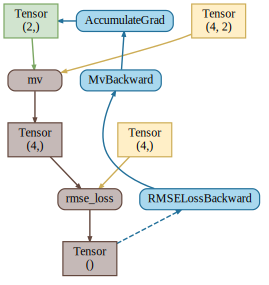

In [6]:
criterion = RMSELoss()
weights = kitty.tensor(init_w1, requires_grad=True)

# visualization
with kitty.CompGraph() as dot:
    y_pred = kitty.mv(X, weights)
    loss = criterion(y_true, y_pred)
dot

In [7]:
# gradient calculation
loss.backward()
weights.grad

tensor([-0.8865, -2.7246])

# Gradient Descent

In [8]:
def mae_loss(y_true, y_pred):
    return (y_true - y_pred).abs().mean()

def huber_loss(y_true, y_pred, delta=1):
    abs_residuals = (y_true - y_pred).abs()
    loss_i = (abs_residuals ** 2) / 2
    loss_i[abs_residuals > delta] = delta * (abs_residuals[abs_residuals > delta] - delta / 2)
    return loss_i.mean()

In [9]:
def train(criterion):
    tracks = []
    losses = []
    
    for init_weights in (init_w1, init_w2):
        weights = kitty.tensor(init_weights, requires_grad=True)
        tracks.append([weights.numpy(copy=True)])
        losses.append([])
        
        # gradient descent
        for _ in range(n_iter):
            weights.grad = None
        
            y_pred = kitty.mv(X, weights)
            loss = criterion(y_true, y_pred)
            loss.backward()
        
            with kitty.no_grad():
                weights -= learning_rate * weights.grad
            
            tracks[-1].append(weights.numpy(copy=True))
            losses[-1].append(loss.item())
            
    return tracks, losses

In [10]:
rmse_loss = RMSELoss()

In [11]:
rmse_tracks, rmse_losses = train(rmse_loss)
mae_tracks, mae_losses = train(mae_loss)
huber_tracks, huber_losses = train(huber_loss)

In [12]:
final_weights = kitty.tensor(rmse_tracks[1][-1], requires_grad=True)
y_pred = kitty.mv(X, final_weights)
rmse_loss(y_true, y_pred).backward()
final_weights.grad.abs().sum()

tensor(7.3835e-06)

A near zero gradient norm means that we have found the optimum. The same can be done for the other weights.

In [13]:
print(
    'RMSE results\n',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*rmse_tracks[0][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*rmse_tracks[0][-1]),
    f'\tLoss: {rmse_losses[0][-1]:.02f}',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*rmse_tracks[1][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*rmse_tracks[1][-1]),
    f'\tLoss: {rmse_losses[1][-1]:.02f}',
    '',
    'MAE results\n',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*mae_tracks[0][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*mae_tracks[0][-1]),
    f'\tLoss: {mae_losses[0][-1]:.02f}',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*mae_tracks[1][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*mae_tracks[1][-1]),
    f'\tLoss: {mae_losses[1][-1]:.02f}',
    '',
    'Huber Loss results\n',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*huber_tracks[0][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*huber_tracks[0][-1]),
    f'\tLoss: {huber_losses[0][-1]:.02f}',
    '\tInitial weights: [{:.02f}, {:.02f}]'.format(*huber_tracks[1][0]),
    '\tFinal weights: [{:.02f}, {:.02f}]'.format(*huber_tracks[1][-1]),
    f'\tLoss: {huber_losses[1][-1]:.02f}',
sep='\n')

RMSE results

	Initial weights: [-0.50, -5.00]
	Final weights: [-3.00, 2.80]
	Loss: 1.64
	Initial weights: [-5.00, 7.60]
	Final weights: [-3.00, 2.80]
	Loss: 1.64

MAE results

	Initial weights: [-0.50, -5.00]
	Final weights: [-0.35, 1.30]
	Loss: 1.50
	Initial weights: [-5.00, 7.60]
	Final weights: [-5.30, 3.70]
	Loss: 1.50

Huber Loss results

	Initial weights: [-0.50, -5.00]
	Final weights: [-2.95, 2.97]
	Loss: 1.00
	Initial weights: [-5.00, 7.60]
	Final weights: [-3.01, 3.00]
	Loss: 1.00


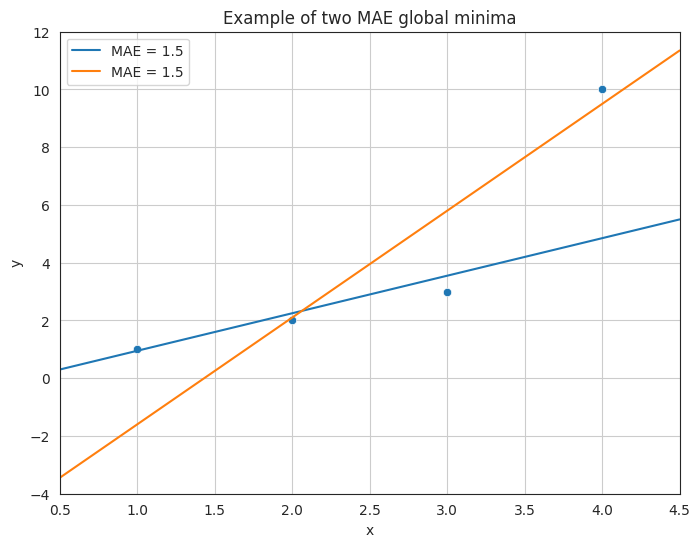

In [14]:
_, ax = plt.subplots(figsize=(8, 6))

x_min, x_max = 0.5, 4.5
ax.set_xlim([x_min, x_max])
ax.set_xlabel('x')

ax.set_ylim([-4, 12])
ax.set_ylabel('y')

ax.set_title('Example of two MAE global minima')
ax.grid()

sns.scatterplot(
    x=X[:, 1],
    y=y_true,
    ax=ax,
)
for i in range(2):
    sns.lineplot(
        x=[x_min, x_max],
        y=[([1, x_min] * mae_tracks[i][-1]).sum(), ([1, x_max] * mae_tracks[i][-1]).sum()],
        label=f'MAE = {mae_losses[i][-1]}',
    )